In [1]:
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import interpolate 
import matplotlib.pyplot as plt
from pathlib import Path
import time
# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *
###
from PIL import Image
###
import imp
import librosa
import librosa.display
import sys
import csv
from scipy.io.wavfile import write
import threading
from IPython.display import clear_output
import helpers as hp
sys.path.append("..")

import torchaudio
import optuna

import helpers
imp.reload(helpers)
imp.reload(pg)
from feature_extraction import pytorch_models as tm

from helpers import *
# from common_vars import SR


drum_names = ['hat', 'kick', 'shake', 'snare']
audio_df = pd.read_csv("csvs/audio_df.csv")
# save_path="./generated_sample_pack/"


import joblib
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

cnet_dvn = tm.Transformer_DVN(attention_dropout=0.3,d_model=120,heads=30,encoding_layers=12,pool_dim=2,)
cnet_dvn = cnet_dvn.load_from_checkpoint(
    "models/transformer/DVNepoch=41-val_accuracy=0.991-val_loss=0.048.ckpt")

cnet_dvd = tm.Transformer_DVD(attention_dropout=0.3,d_model=100,heads=20,encoding_layers=12,pool_dim=1,pct_start=0.05,max_lr=1e-4,max_momentum=0.95,epochs=50)
cnet_dvd = cnet_dvd.load_from_checkpoint(
    "models/transformer/DVDepoch=59-val_accuracy=0.917-val_auc=0.9779-val_loss=0.327.ckpt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet_dvn.to(device)
cnet_dvd.to(device)
pass 



## Percussive Sound Generation with Virtual Listeners and Modular Synthesizers
#### Candidate: Amir Salimi
#### Supervisor: Abram Hindle

### Topics:
1. Introduction 5 min
2. Background  5 min 
3. Virtual Synthesis 5 min
4. Virtual Ear 7.5 min
5. Survey and Results 5 min
6. Drum Kit Mutation 5 min
7. Future Work and Conclusion 7.5 min

### 1. Introduction
- Motivation
- Methodology
- Contribution

1.1: Motivation:
- Drum sounds are used in electronic music
- Original Drum sounds are hard to make 

1.2: Methodology

1.3: Contributions:
- Create sounds
- Curate datasets of drums (share it with others)
- Create a listeners that prefer drums
- Listeners judge sounds
- Keep sounds that are judged positively

### 3: Virtual Synthesis

CPU times: user 259 ms, sys: 3.96 ms, total: 263 ms
Wall time: 228 ms


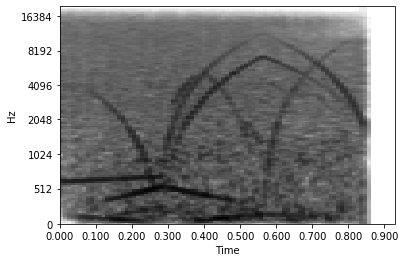

In [117]:
%%time
out = dsp.buffer(length = 1, channels = 1)
params,stack_num = [],32

params = [pg.RandomParams() for i in range(stack_num)]
sound = pg.ensemble(params)

hp.get_mel_spec(sound)
Audio(sound,rate = sr, autoplay = True)

## 4: Virtual Ears
- How do we represent sounds? 
- We take two approaches to virtual ears:
    - Two Phased Ears
    - Mixed Ear Models

### 4.1 Sound Representation:

In [3]:
####
#defining transformations
spec=torchaudio.functional.spectrogram
FREQ_BINS=30
TIME_STEPS=100
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        print(wf)
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s= self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()
        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

def MakeSpecs(tfList, plt,a_sample):
    for i, tsfrm in enumerate(tfList):
        transformed_sample = tsfrm(a_sample)
        ax = plt.subplot(1, 3, i + 1)
        plt.tight_layout()
        ft=transformed_sample["feats"]
        if i==0:
            plt.title("Frequency Features",fontsize=20)
            plt.xlabel("Frequency Bin",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==1:
            plt.title("Envelope Features",fontsize=20)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)            
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==2:
            print(ft.shape,)
            sf=ft.detach().numpy()
            ft=ft.detach().numpy()
            plt.title("Spectrum Features",fontsize=20)
            librosa.display.specshow(sf,cmap='gray_r',)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Magnitude of Bin",fontsize=20)


def sample_sound():
    df = audio_df[audio_df["maj"]=="drums"]
    random_row = np.random.randint(len(df))
    row = df.iloc[random_row]
    audio = librosa.load(row["path"])[0]
    major,minor = row["maj"],row["min"]
    return {"signal":torch.tensor(audio),"label":major,"path":'',"drum_type":minor}


# make sound and evaluate
def make_and_eval(stack_size = 1):
    out,params = StackMaker(stack_size)
    a = memToAud(out)
    try:
        signal = torch.tensor(librosa.resample(a.reshape(-1),SR,SR//2))[0:SR//4]
    except Exception as e:
        signal = torch.tensor(np.zeros([1,1,SR//4])).float()
    with torch.no_grad():
        cnet_dvn.eval()
        ps_dvn = cnet_dvn(signal.reshape(1,-1).to(device))
        ps_dvd = cnet_dvd(signal.reshape(1,-1).to(device))
        
#         print(dict(zip(drum_types,ps_dvd[0].numpy())))
    return a,signal,ps_dvn.cpu(),ps_dvd.cpu()

tensor([-0.0145,  0.0170, -0.0180,  ...,  0.0036,  0.0014, -0.0014])
torch.Size([30, 17])


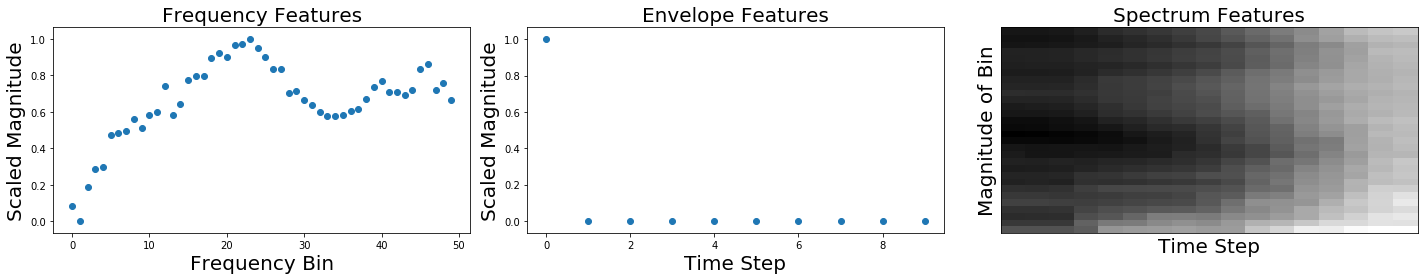

In [120]:
from feature_extraction import pytorch_models as pm
import torchaudio

fig = plt.figure(figsize=(20,4))
sample = sample_sound()
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]
MakeSpecs(tfList, plt,sample)
Audio(sample["signal"],rate=SR,autoplay=True)

##### What can we learn from these features?
- We need a virtual ear to make quick decisions
    - Decision 1: Drum vs Not Drum
    - Decision 2: Different types of drums

#### Virtual Ears: Model Types:
- Two Phased Ears
   - Decision 1, then Decision 2
- Mixed Ear Models:
    - Further condense the representation and make both decisions together

#### Two Phased Ears:
- Implementation
- Example Outputs (Good and Bad)

#### Mixed Ear Models:
- Implementation
- Example Outputs (Good and Bad)

### 5. Survey and Results 
- 5.1 How a generative system is put together 
- 5.2 TPE Surveys
- 5.3 MEM surveys
- 5.4 Survey Comparisons

In [111]:
#5.1 Finding drums via random sound generation
biggest_p = []
best_sounds = {}
for i in range(300):
    synth_out,a,ps,ps_dvd = make_and_eval(1)
    print("number of attempts:",i,end="\r")
    if ps[0].item() > 1 and a.sum():
        clear_output()
        print("after %d attempts"%i)
        print("found a ",drum_names[np.argmax(ps_dvd)],"with probability: %f"%ps[0].item())
        break
    biggest_p.append(ps[0])
a = a.reshape([-1]).cpu().numpy()[0:SR//4]
anorm =  librosa.util.normalize(a)
Audio(anorm[0:SR//6].reshape([-1]),rate=SR//2,autoplay=True)


after 106 attempts
found a  snare with probability: 3.322531


### Fleiss Kappa Coefficients for  TPE Survey
| Drop Rule                           | Size | H\+H   | H\+FC | H\+CNN | H\+E/F | 3 models |
|-------------------------------------|------|-------|-------|--------|--------|----------|
| No Drops                            | 257  | 0\.37 | 0\.35 | 0\.36  | 0\.36  | 0\.28    |
| Assigned "Bad" By Both              | 236  | 0\.31 | 0\.37 | 0\.37  | 0\.38  | 0\.30    |
| Assigned "Bad" By Either            | 180  | 0\.47 | 0\.50 | 0\.48  | 0\.48  | 0\.34    |
| Assigned "Bad" or "Other" By Either | 154  | 0\.47 | 0\.59 | 0\.54  | 0\.50  | 0\.35    |


### Fleiss Kappa Coefficients for MEM Survey
| Drop Rule                           | Size | HvH    | H\+MME |
|-------------------------------------|------|--------|--------|
| No Drop                             | 300  | 0\.336 | 0\.250 |
| Assigned "Bad" By Both              | 249  | 0\.200 | 0\.260 |
| Assigned "Bad" By Either            | 151  | 0\.460 | 0\.473 |
| Assigned "Bad" or "Other" By Either | 120  | 0\.620 | 0\.587 |

### 6. Drum Kit Mutation
- Can our systems be used to make drum-kits?
- Can we make drum-kits during live performances?

### 7. Search (work in progress)
- Only random search was used in this work
- Searching the paramter space can speed up generation

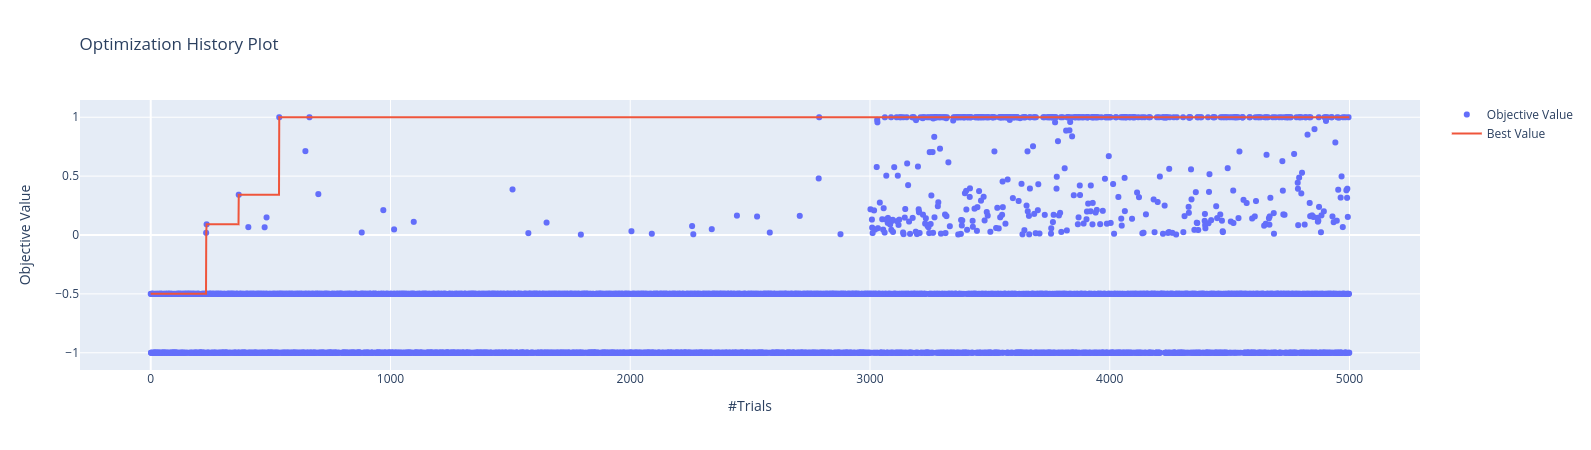

In [107]:
drum_names = ['hat', 'kick', 'shake', 'snare']
dt = 1
study_name = "HyperBand_%s"%drum_names[dt]
study = joblib.load("studies/%s_study.pkl"%study_name)
space = optuna.samplers.intersection_search_space(study)
plot_optimization_history(study)

In [108]:
num_invalids = 0
for i in range(100):
    try:
        print(i,end="\r")
        params = study.sampler.sample_relative(study,optuna.trial._frozen.FrozenTrial,space)
        program = pg.StackParams()
        program.__dict__ = dict(zip(program.__dict__.keys(),params.values()))
        out = dsp.buffer(length=1,channels=1)
        s = pg.Synth(program)
        out.dub(s.buff,program.getStart())
        out = fx.norm(out,1)
        sound = hp.memToAud(out)
        
        signal = torch.tensor(librosa.resample(sound.reshape(-1),SR,SR//2)).to(device)[0:SR//4].reshape(1,-1)
        cnet_dvn.eval(),cnet_dvd.eval()
        with torch.no_grad():
            score_dvn = cnet_dvn(signal).item()
            score_dvd = cnet_dvd(signal)[0][dt].item()
        
        if (score_dvn < -1 or score_dvd < 0):
            pass
        else:
            print("attempt->%d, invalid programs->%d\n"%(i,num_invalids))
            print(score_dvn,score_dvd)
            break
    except:
        num_invalids += 1
        pass 
Audio(sound,rate=SR, autoplay=True)

attempt->2, invalid programs->1

1.3614567518234253 8.353184700012207
